## Data Loading

### Get Public Dataset

Get the LangSmith public dataset for semi-structured data, `Semi-structured Reports`.

In [ ]:
%pip install --quiet -U langchain langsmith langchainhub  langchain_benchmarks
%pip install --quiet chromadb openai "unstructured[all-docs]"

## Data Loading

### Get Public Dataset

Get the LangSmith public dataset for semi-structured data, `Semi-structured Reports`.

In [2]:
import os
from pathlib import Path

from langchain_benchmarks import clone_public_dataset, registry
from langchain_benchmarks.rag.tasks.semi_structured_reports import get_file_names

# Task
task = registry["Semi-structured Reports"]
task

Name,Semi-structured Reports
Type,RetrievalTask
Dataset ID,c47d9617-ab99-4d6e-a6e6-92b8daf85a7d
Description,Questions and answers based on PDFs containing tables and charts. The task provides the raw documents as well as factory methods to easily index them and create a retriever. Each example is composed of a question and reference answer. Success is measured based on the accuracy of the answer relative to the reference answer. We also measure the faithfulness of the model's response relative to the retrieved documents (if any).
Retriever Factories,"basic, parent-doc, hyde"
Architecture Factories,
get_docs,


In [3]:
# Files used
paths = list(get_file_names())
files = [str(p) for p in paths]

### Base Case

PDF loader (naive to tables).

In [4]:
from langchain.document_loaders import PyPDFLoader


def load_and_split(file):
    """
    Load and split PDF files
    """

    loader = PyPDFLoader(file)
    pdf_pages = loader.load()

    # Split
    from langchain.text_splitter import RecursiveCharacterTextSplitter

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=2000, chunk_overlap=50
    )

    # Get chunks
    docs = text_splitter.split_documents(pdf_pages)
    texts = [d.page_content for d in docs]
    print(f"There are {len(texts)} text elements")
    return texts


baseline_texts = []
for fi in files:
    baseline_texts += load_and_split(fi)

There are 11 text elements
There are 3 text elements


### Unstructured

Table-aware splitting following cookbook [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/Semi_Structured_RAG.ipynb).

In addition to the below pip packages, you will also need [poppler](https://pdf2image.readthedocs.io/en/latest/installation.html) and [tesseract](https://tesseract-ocr.github.io/tessdoc/Installation.html) in your system.

In [5]:
%pip install "unstructured[all-docs]" --upgrade --quiet

Note: you may need to restart the kernel to use updated packages.


In [6]:
from unstructured.partition.pdf import partition_pdf


def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


def parse_pdf_unstructured(file):
    # Get elements
    unstructured_elements = partition_pdf(
        filename=file,
        extract_images_in_pdf=False,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=os.path.dirname(file),
    )

    # Categorize elements by type
    texts, tables = categorize_elements(unstructured_elements)
    print(f"There are {len(tables)} tables")
    print(f"There are {len(texts)} text elements")
    return texts, tables


# Run
unstructured_texts = []
unstructured_tables = []
for fi in files:
    texts, tables = parse_pdf_unstructured(fi)
    unstructured_texts += texts
    unstructured_tables += tables

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


There are 9 tables
There are 11 text elements
There are 1 tables
There are 5 text elements


### Docugami

Use table-aware splitting following cookbook [here](https://github.com/langchain-ai/langchain/blob/master/cookbook/docugami_xml_kg_rag.ipynb).

In [7]:
%pip install --quiet -U docugami==0.0.8 dgml-utils==0.3.0

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
kubernetes 28.1.0 requires urllib3<2.0,>=1.24.2, but you have urllib3 2.1.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from docugami import Docugami
from docugami.lib.upload import upload_to_named_docset, wait_for_dgml

# Load
DOCSET_NAME = "Semi-Structured"

dg_client = Docugami()
dg_docs = upload_to_named_docset(dg_client, files, DOCSET_NAME)
dgml_paths = wait_for_dgml(dg_client, dg_docs)

dgml_paths

{'3Q23_Earnings_Press_Release.pdf': '/var/folders/0h/6cchx4k528bdj8cfcsdm0dqr0000gn/T/tmppfmb_f0s',
 'IF10055.pdf': '/var/folders/0h/6cchx4k528bdj8cfcsdm0dqr0000gn/T/tmp9amxbd5r'}

In [9]:
from io import BytesIO
from PIL import Image
import requests
import tempfile

from docugami.types import Document as DgDocument

from dgml_utils.segmentation import get_chunks_str
from dgml_utils.models import BoundingBox


def download_bbox_image(dg_doc: DgDocument, bbox: BoundingBox) -> Path:
    page_image_url = dg_doc.url + f"/pages/{bbox.page}/content"

    # Download the full page image
    response = requests.get(url=page_image_url, headers=dg_client.auth_headers)
    if not response.ok:
        raise ValueError(f"Failed to download page image: {page_image_url}")

    # Crop and save only the given bbox inside the full page image
    image = Image.open(BytesIO(response.content))
    cropped_image = image.crop(
        (bbox.left, bbox.top, bbox.left + bbox.width, bbox.top + bbox.height)
    )
    temp_file = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
    cropped_image.save(temp_file.name, format="JPEG")

    return Path(temp_file.name)


def extract_docugami_file(dg_doc: DgDocument, dgml_path: Path):
    with open(dgml_path, "r") as file:
        contents = file.read().encode("utf-8")

        # Chars to OpenAI token math ref:
        # https://help.openai.com/en/articles/4936856-what-are-tokens-and-how-to-count-them
        chunks = get_chunks_str(
            contents,
            min_text_length=1024 * 2,  # 2k chars are ~0.5k tokens
            max_text_length=1024 * 8,  # 8k chars are ~2k tokens
        )

    # Table texts
    table_texts = []
    table_image_paths = []
    for c in chunks:
        if "table" not in c.structure.split():
            continue
        table_texts.append(c.text)
        for bbox in c.bboxes:
            table_image_paths.append(download_bbox_image(dg_doc, bbox))
    print(f"There are {len(table_texts)} table elements")

    # Text
    texts = [c.text for c in chunks if "table" not in c.structure.split()]
    print(f"There are {len(texts)} text elements")

    return texts, table_texts, table_image_paths


docugami_texts = []
docugami_tables = []
docugami_table_image_paths = []
for fname in files:
    # Get xml
    f_name = Path(fname).name
    dgml_path = dgml_paths[f_name]
    dg_doc = [d for d in dg_docs if d.name == f_name][0]

    # Extract elelemtns
    texts, tables, table_image_paths = extract_docugami_file(dg_doc, dgml_path)
    docugami_texts += texts
    docugami_tables += tables
    docugami_table_image_paths += table_image_paths

There are 9 table elements
There are 6 text elements
There are 1 table elements
There are 5 text elements


## Indexing

### Base case

In [10]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores.chroma import Chroma

vectorstore_baseline = Chroma.from_texts(
    texts=baseline_texts, collection_name="baseline", embedding=OpenAIEmbeddings()
)

retriever_baseline = vectorstore_baseline.as_retriever()

### Multi-vector retriever

In [11]:
import uuid

from langchain.chat_models.openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema import Document, StrOutputParser
from langchain.storage import InMemoryStore


def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatOpenAI(temperature=0, model="gpt-4")
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


def create_multi_vector_retriever(
    vectorstore,
    text_summaries=None,
    texts=None,
    table_summaries=None,
    tables=None,
    image_summaries=None,
    images=None,
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever

In [12]:
## Unstructured

# Get text, table summaries
unstructured_text_summaries, unstructured_table_summaries = generate_text_summaries(
    unstructured_texts, unstructured_tables, summarize_texts=False
)

# The vectorstore to use to index the summaries
unstructured_vectorstore = Chroma(
    collection_name="unstructured", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_unstructured = create_multi_vector_retriever(
    unstructured_vectorstore,
    unstructured_text_summaries,
    unstructured_texts,
    unstructured_table_summaries,
    unstructured_tables,
)

In [13]:
## Docugami

# Get text, table summaries
docugami_text_summaries, docugami_table_summaries = generate_text_summaries(
    docugami_texts, docugami_tables, summarize_texts=False
)

# The vectorstore to use to index the summaries
docugami_vectorstore = Chroma(
    collection_name="docugami", embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_docugami = create_multi_vector_retriever(
    docugami_vectorstore,
    docugami_text_summaries,
    docugami_texts,
    docugami_table_summaries,
    docugami_tables,
)

### Multi-vector retriever w/ images

Images extracted from the tables

In [14]:
import base64
from typing import List

from langchain.schema.messages import HumanMessage


def encode_image(image_path: Path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(img_base64: str, prompt: str):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content


def generate_img_summaries(paths: List[Path]):
    """
    Generate summaries and base64 encoded strings for images
    paths: List of image file paths (JPEG)
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in paths:
        if img_file.suffix.lower() in [".jpg", ".jpeg"]:
            base64_image = encode_image(img_file)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries

In [15]:
docugami_table_image_base64_list, docugami_table_image_summaries = generate_img_summaries(docugami_table_image_paths)

In [16]:
# The vectorstore to use to index the summaries
multi_modal_vectorstore = Chroma(
    collection_name="multi_modal", embedding_function=OpenAIEmbeddings()
)

retriever_docugami_multi_vector_img = create_multi_vector_retriever(
    multi_modal_vectorstore,
    texts=docugami_texts,
    text_summaries=docugami_text_summaries,
    image_summaries=docugami_table_image_summaries,
    images=docugami_table_image_base64_list,
)

## RAG

In [17]:
from langchain.schema.runnable import RunnablePassthrough


def rag_chain(retriever):
    """
    RAG chain
    """

    # Prompt template
    template = """Answer the question based only on the following context, which can include text and tables:
    {context}
    Question: {question}
    """
    prompt = ChatPromptTemplate.from_template(template)

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4")

    # RAG pipeline
    chain = (
        {"context": retriever, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    return chain


# Create RAG chains
chain_baseline = rag_chain(retriever_baseline)
chain_unstructured = rag_chain(retriever_unstructured)
chain_docugami = rag_chain(retriever_docugami)

### Image

In [18]:
import io
import re

from IPython.display import HTML, display
from PIL import Image

from langchain.schema.runnable import RunnableLambda


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are an analyst tasking with providing advice basded on images.\n"
            "You may be given a mix of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide analysis related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


chain_docugami_multimodal = multi_modal_rag_chain(retriever_docugami_multi_vector_img)

## Check


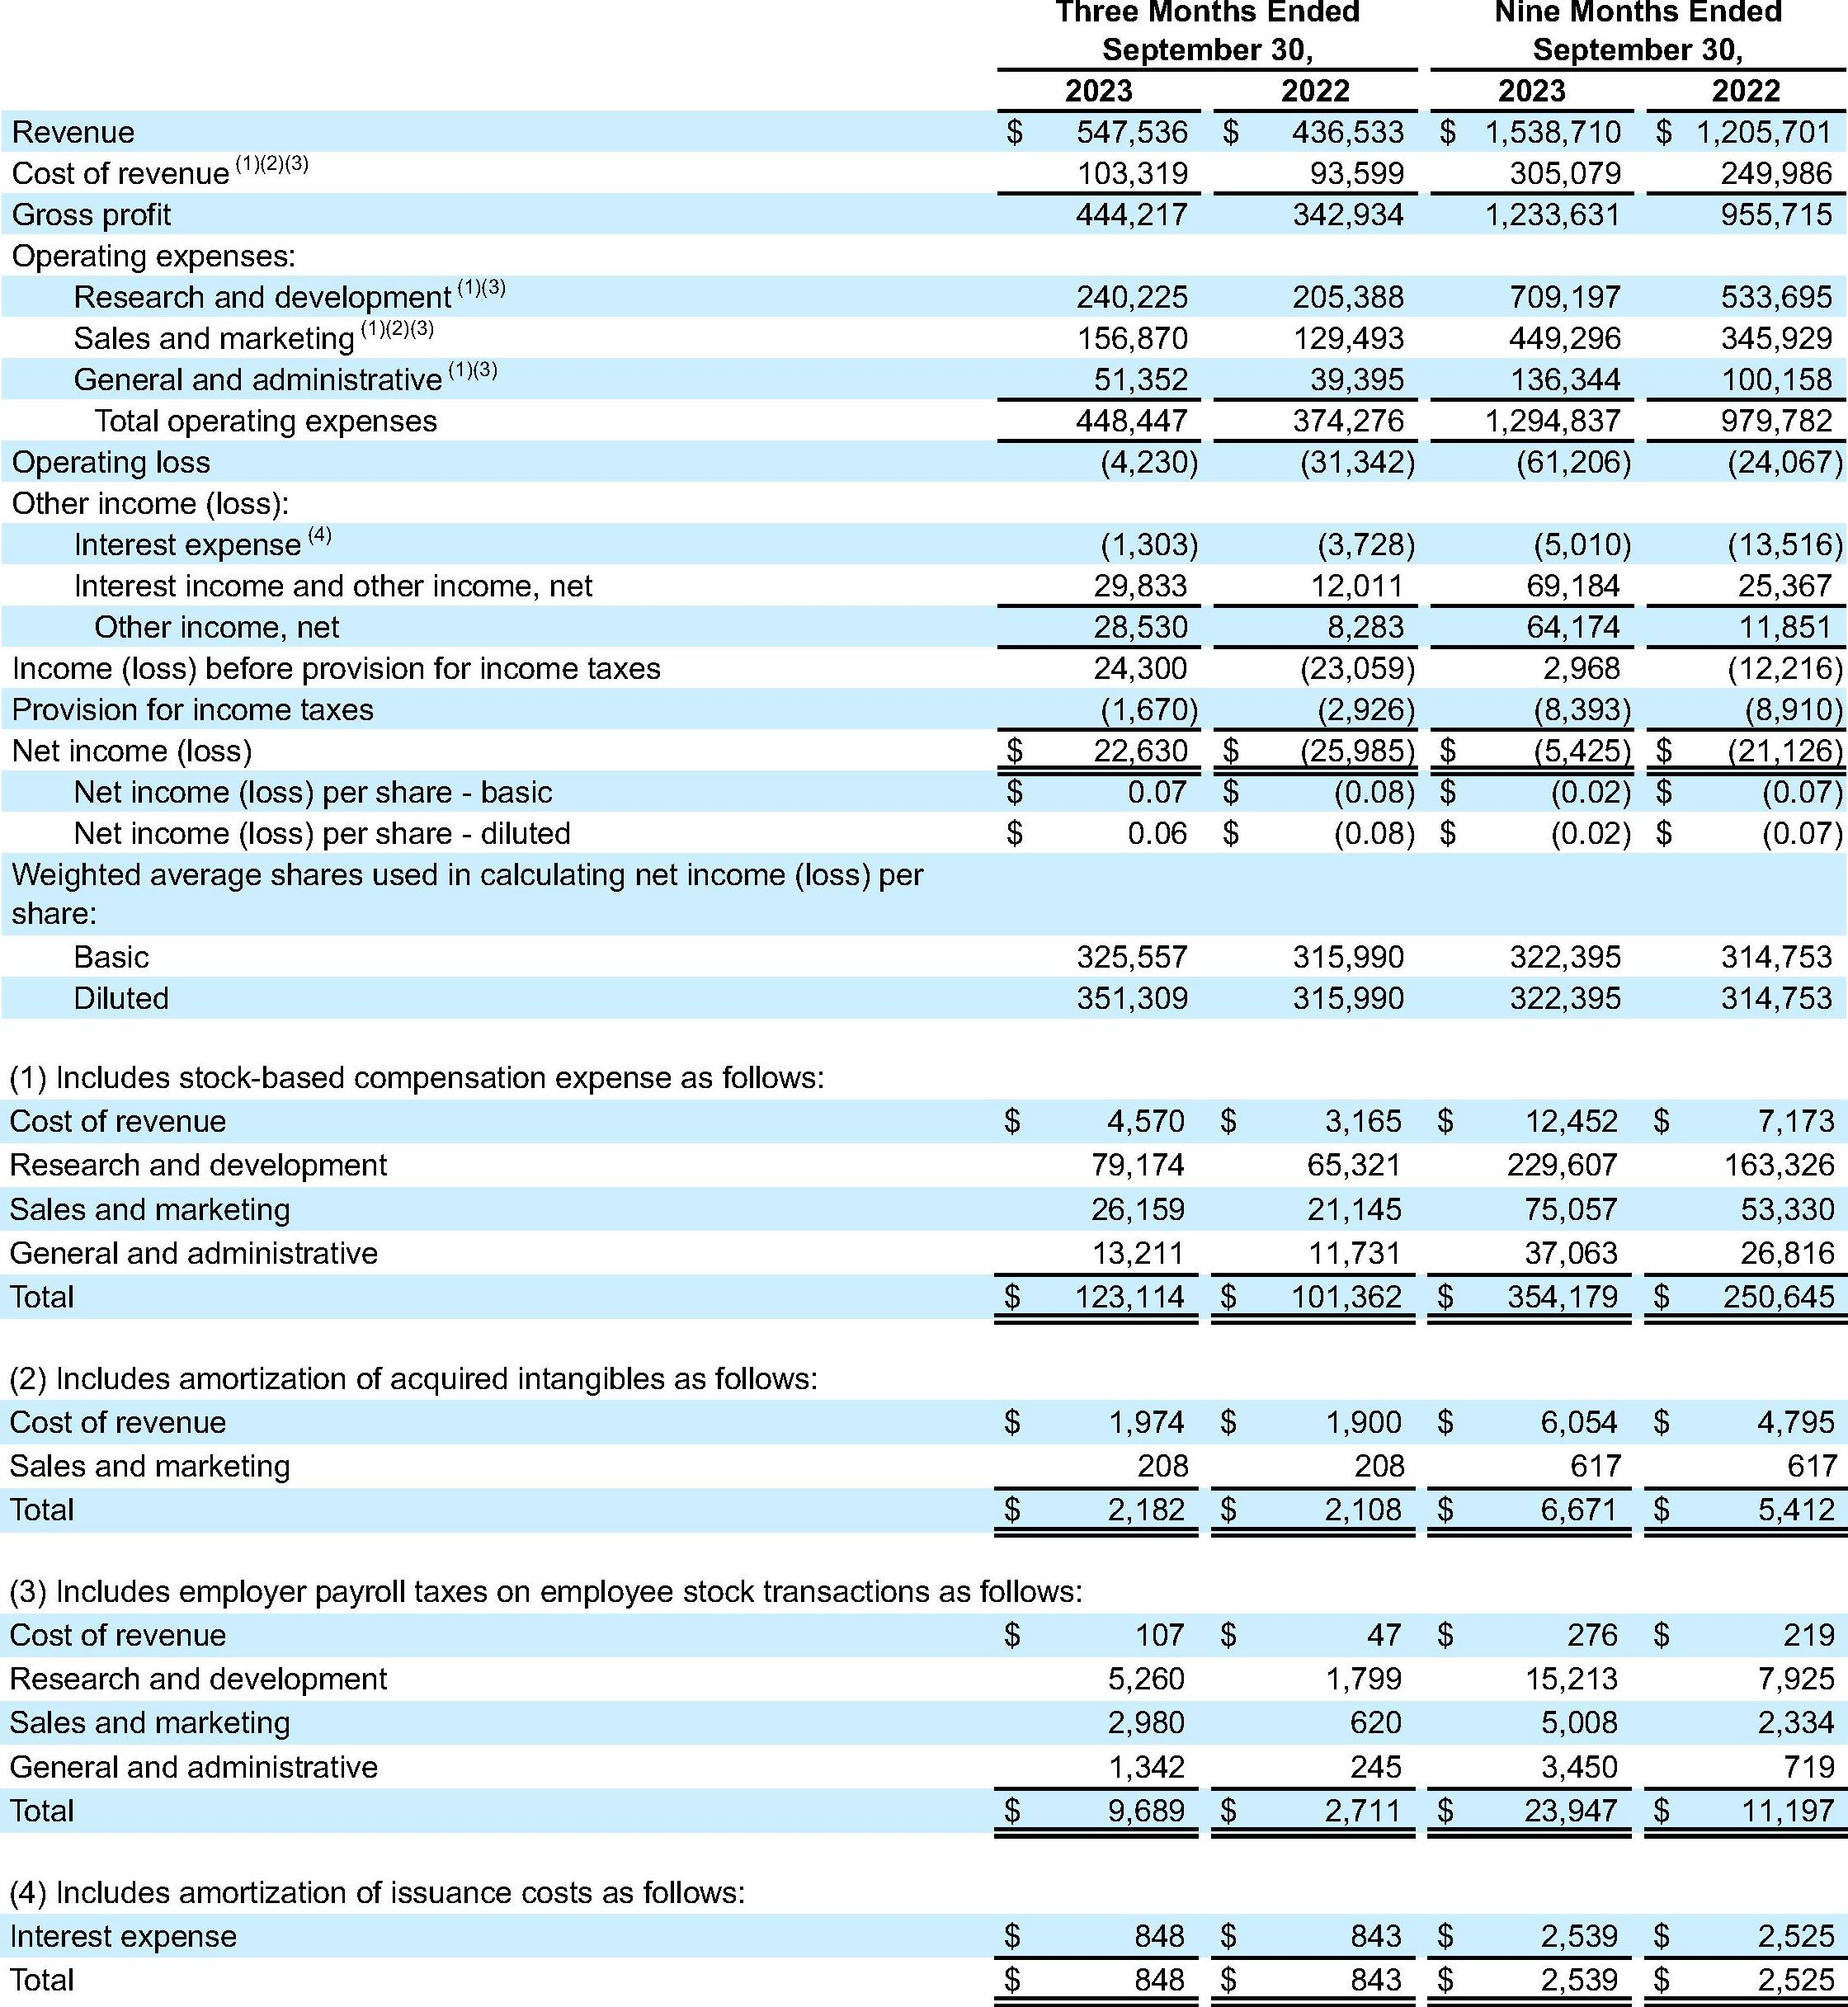

In [19]:
# Check retrieval
query = "Analyzing the operating expenses for Q3 2023, which category saw the largest increase when compared to Q3 2022?"
docs = retriever_docugami_multi_vector_img.get_relevant_documents(query, limit=6)

# Check that we get back relevant images
plt_img_base64(docs[0])

# Eval

See guide [here](https://github.com/langchain-ai/langchain-benchmarks/blob/main/docs/source/notebooks/retrieval/semi_structured.ipynb).

In [20]:
clone_public_dataset(task.dataset_id, 
                     dataset_name=task.name)

Dataset Semi-structured Reports already exists. Skipping.
You can access the dataset at https://smith.langchain.com/o/530c4d06-5640-4c0f-94fe-0be7b769531f/datasets/0698900e-f708-46ab-b9d8-b5eef86ff796.


In [ ]:
from functools import partial

from langsmith.client import Client

from langchain_benchmarks.rag import get_eval_config


def run_eval(chain, eval_run_name):
    """
    Run eval
    """
    client = Client()
    test_run = client.run_on_dataset(
        dataset_name=task.name,
        llm_or_chain_factory=lambda: (lambda x: x["question"]) | chain,
        evaluation=get_eval_config(),
        verbose=True,
        project_name = eval_run_name
    )


# Experiments
chain_map = {
    "baseline": chain_baseline,
    "unstructured": chain_unstructured,
    "docugami_multimodal": chain_docugami_multimodal,
    "docugami_text": chain_docugami,
}

for project_name, chain in chain_map.items():
    run_eval(chain, project_name)